# Bet hetging as a maternal strategy in a fluctuating environment

In [1]:
import numpy as np
from scipy.stats import multivariate_normal as multinom
from scipy.stats import norm
from statsmodels.tsa.arima_process import ArmaProcess
import matplotlib.pyplot as plt
from seaborn import heatmap
import pdb

#### Parameters

In [28]:
x0       = (1,0.1,0.1) #Initial conditions. The first term is the mean genetic value of z, the second term is the parameter of sensitivity to maternal environment m and the third term is the maternal value for m
tau      = 100 #Lifespan
nbsteps  = 20#Number of selective episodes in an organism’s lifetime
w2       = 10*tau #Inverse selection strength (constant)

V0       = (0.5,0.01) #Genetic variance (again for l, m)
Vr       = [0.3,0.005] #This is the variability during reproduction, in the infinitesimal model

rho      = 0.5 #Autocorrelation of the environment, careful exprho = exp(-rho delta) for delta the discretization step in time and rho the continuous autocorrelation used in the text
sig2_e   = 1 #Variance in the environment

gridsize = [100,50] #This will be the size of the grid which will contain the density
gridlim  = np.array([[-5,5],[-1,1]]) #grid limits in l and m
Tmax     = 5000

#### Environment

In [29]:
def GenerateEnvironment(r=rho, s2=sig2_e, n = nbsteps*Tmax, time=tau*Tmax):
    """This function, for a given autocorrelation r and environmental standard deviation s, generates an AR[1] sequence of length n
    Keep in mind that a discretized (in steps of size dt) O-U process with parameters (r,s2) is an AR[1] process with parameters (exp(-rho dt), sqrt(s2(1-exp(-2rho dt))))"""
    x= ArmaProcess([1,-np.exp(-r*time/n)]).generate_sample(n,scale=np.sqrt(s2*(1-np.exp(-2 * r *time/n))))
    return x

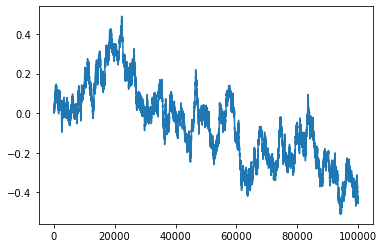

In [30]:
plt.plot(GenerateEnvironment(time = (Tmax+1)*nbsteps,r=rho/100000))

### Numerical integration:
Here we represent the population by its discretized density, and, assuming that it is remains Gaussian, we find its evolution

In [39]:
def W(x,m,th,signal):
    """This is our fitness function"""
    return np.exp(-1/(w2+signal*m**2)*(x-th)**2)/np.sqrt(1+signal*m**2/w2)

def TransformtoPosition(y: list):
    """This yields the position in space corresponding to an index of the grid"""
    if len(y)==2:
        return [gridlim[0,0]*(1-y[0]/gridsize[0]) + gridlim[0,1]*y[0]/gridsize[0],
               gridlim[1,0]*(1-y[1]/gridsize[1]) + gridlim[1,1]*y[1]/gridsize[1]]
    elif len(y)==3:
        return [gridlim[0,0]*(1-y[0]/gridsize[0]) + gridlim[0,1]*y[0]/gridsize[0],
               gridlim[1,0]*(1-y[1]/gridsize[1]) + gridlim[1,1]*y[1]/gridsize[1],
               gridlim[1,0]*(1-y[2]/gridsize[1]) + gridlim[1,1]*y[2]/gridsize[1]]
    else:
        raise ValueError("y is either a list (l,m,mprev) or a list (l,m)")

def Getmean(grid):
    """Grid is a 3-dimensionnal probability density"""
    return np.array([np.sum(np.sum(grid,axis=(1,2))*np.linspace(gridlim[0,0],gridlim[0,1],gridsize[0])),
                      np.sum(np.sum(grid,axis=(0,2))*np.linspace(gridlim[1,0],gridlim[1,1],gridsize[1])),
                      np.sum(np.sum(grid,axis=(0,1))*np.linspace(gridlim[1,0],gridlim[1,1],gridsize[1]))])

def Getvar(grid,means=[]):
    if len(means)==0:
        means=Getmean(grid)
    return np.array([np.sum(np.sum(grid,axis=(1,2))*np.linspace(gridlim[0,0],gridlim[0,1],gridsize[0])**2),
                      np.sum(np.sum(grid,axis=(0,2))*np.linspace(gridlim[1,0],gridlim[1,1],gridsize[1])**2),
                      np.sum(np.sum(grid,axis=(0,1))*np.linspace(gridlim[1,0],gridlim[1,1],gridsize[1])**2)])-means**2

def Getcovarlm(grid,means=[]):
    """This yields the covariance between l and m"""
    if len(means)==0:
        means=Getmean(grid)
    #Square matrix of product of coordinates in l and m
    matrixlm = np.array(np.transpose(np.matrix(np.linspace(gridlim[0,0],gridlim[0,1],gridsize[0])))*np.linspace(gridlim[1,0],gridlim[1,1],gridsize[1]))
    return np.sum(np.sum(grid,axis=2)*matrixlm)-means[0]*means[1]

def Getcovarmm(grid,means=[]):
    """This yields the covariance between m and maternal m"""
    if len(means)==0:
        means=Getmean(grid)
    #Square matrix of product of coordinates in l and m
    matrixmm = np.array(np.transpose(np.matrix(np.linspace(gridlim[1,0],gridlim[1,1],gridsize[1])))*np.linspace(gridlim[1,0],gridlim[1,1],gridsize[1]))
    return np.sum(np.sum(grid,axis=0)*matrixlm)-means[0]*means[1]

def Getvarcovar(grid,means=[]):
    if len(means)==0:
        means=Getmean(grid)
    listvars = Getvar(grid,means)
    covarlm  = Getcovarlm(grid,means)
    return np.matrix([[listvars[0],covarlm,      covarlm/4    ],
                     [covarlm,     listvars[1],  listvars[1]/2],
                     [covarlm/4,   listvars[1]/2,listvars[1]  ]])
    #Note that the variance - covariance structure of the maternal m is of no importance for the new generation, 
    #since the mothers become grandmothers in the next generation, and since the covariance between mother and offspring
    #is always half the variance of the mother



In [32]:
def PostSelection(grid,th,signal):
    """This ponders the density by the fitness"""
    grid      = grid*np.array([[W(l,np.linspace(gridlim[1,0],gridlim[1,1],gridsize[1]),th,signal)
                           for m in np.linspace(gridlim[1,0],gridlim[1,1],gridsize[1])]
                          for l in np.linspace(gridlim[0,0],gridlim[0,1],gridsize[0])])
    grid      = grid/np.sum(grid)
    return grid


In [33]:
def GenerateTrajectory(x0=x0,Tmax=Tmax,w2=w2,V0=V0,Vr=Vr,rho=rho,sig2_e=sig2_e):
    """This function generates the trajectory of a population """
    x          = x0
    z          = x0[0]
    th         = GenerateEnvironment(time = (Tmax+1)*nbsteps,r=rho)
    thvarprev  = np.var(th[0:nbsteps])
    #The grid has 3 coordinates: l, m, and maternal m
    varcovarx  =[[V0[0],0,       0      ],#We start with no linkage
                [0,     V0[1],   V0[1]/2],
                [0,     V0[1]/2, V0[1]  ]]
    law = multinom(x,varcovarx) 
    grid       = np.array([[[law.pdf([l,m,mprev]) 
                            for mprev in np.linspace(gridlim[1,0],gridlim[1,1],gridsize[1])]
                           for m in np.linspace(gridlim[1,0],gridlim[1,1],gridsize[1])]
                          for l in np.linspace(gridlim[0,0],gridlim[0,1],gridsize[0])])
    grid       = grid/np.sum(grid)

    listx      = [[0]*6]*Tmax #7 for: l,m,mm,varl,varm,varmm,th
    for t in range(Tmax):
        thmean   = np.mean(th[(t+1)*nbsteps:(t+2)*nbsteps])
        thvar    = np.var(th[(t+1)*nbsteps:(t+2)*nbsteps])
        law      = multinom(x,varcovarx)
        grid     = np.array([[[law.pdf([l,m,mprev]) 
                            for mprev in np.linspace(gridlim[1,0],gridlim[1,1],gridsize[1])]
                           for m in np.linspace(gridlim[1,0],gridlim[1,1],gridsize[1])]
                          for l in np.linspace(gridlim[0,0],gridlim[0,1],gridsize[0])])
        grid      = PostSelection(grid,thmean,thvarprev)
        x         = Getmean(grid)
        varcovarx = Getvarcovar(grid,x)/2 + np.diag(Vr+[0])
        listx[t]  = list(x)+[varcovarx[0,0]]+[varcovarx[1,1]]+[varcovarx[1,0]]
    heatmap(grid)
    return np.transpose(listx)

C:\Users\courau\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\courau\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\courau\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\courau\Anaconda3\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\courau\Anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


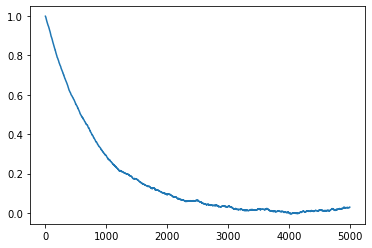

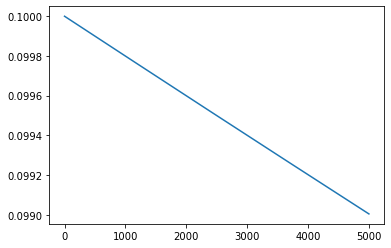

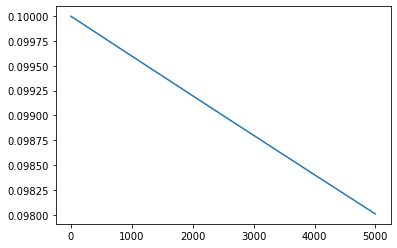

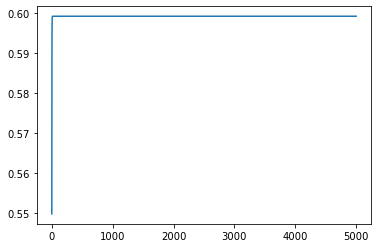

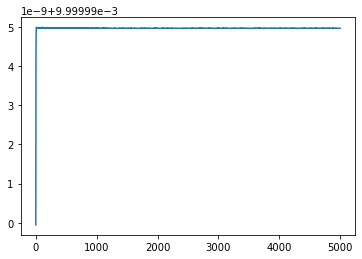

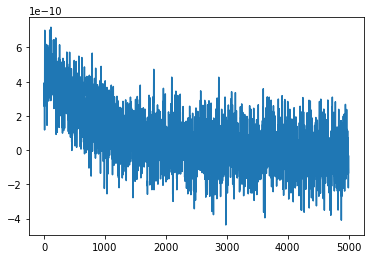

In [34]:
test1=GenerateTrajectory()
plt.figure()
plt.plot(test1[0])
plt.figure()
plt.plot(test1[1])
plt.figure()
plt.plot(test1[2])
plt.figure()
plt.plot(test1[3])
plt.figure()
plt.plot(test1[4])
plt.figure()
plt.plot(test1[5])